Epoch 1/10
14080/14112 [============================>.] - ETA: 0s - loss: 0.0232  

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


14240/14112 [==============================] - 38s - loss: 0.0233 - val_loss: 0.0164
Epoch 2/10
14120/14112 [==============================] - 36s - loss: 0.0189 - val_loss: 0.0173

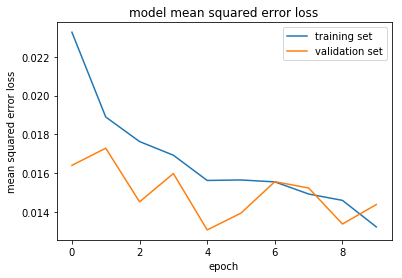

In [2]:
import os
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Flatten, Dense, Convolution2D, Activation, MaxPooling2D
from keras.layers import Lambda, Cropping2D
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
%matplotlib inline

# The amount of "correction" in angle to specify for the left and right cameras
# This is a parameter to tune
CORRECTION = 0.1 

def get_image(full_path):
    return cv2.imread('./data/IMG/' + full_path.split('/')[-1])
     
samples = []
with open('./data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

# Creating validation dataset 20% the size of the data set
train_samples, validation_samples = train_test_split(
    samples, test_size=0.2, random_state=49)

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while True:
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset + batch_size]

            images = []
            angles = []
            for sample in batch_samples:
                center_image = get_image(sample[0])
                center_angle = float(sample[3])
                images.append(center_image)
                angles.append(center_angle)

                flipped_image = np.fliplr(center_image)
                flipped_angle = -center_angle

                left_angle = center_angle + CORRECTION
                right_angle = center_angle - CORRECTION

                left_image = get_image(sample[1])
                right_image = get_image(sample[2])

                # add images and angles to data set
                images.extend([center_image, left_image,
                               right_image, flipped_image])
                angles.extend([center_angle, left_angle,
                               right_angle, flipped_angle])

            X_train = np.array(images)
            y_train = np.array(angles)

            yield X_train, y_train

train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

model = Sequential()

# Data normalization
model.add(Lambda(lambda x: (x / 255) - 0.5, input_shape=(160, 320, 3)))

# Implemenation of the Nvidia neural network architecture
model.add(Cropping2D(cropping=((50, 10), (0, 0))))
model.add(Convolution2D(24, 5, 5, subsample=(2, 2), activation="relu"))
model.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation="relu"))
model.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation="relu"))
model.add(Convolution2D(64, 5, 5, activation="relu"))
model.add(Convolution2D(64, 5, 5, activation="relu"))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')

# To see more details regarding the model
# print(model.summary())

history_object = model.fit_generator(train_generator, samples_per_epoch=len(train_samples) * 4,
                                     validation_data=validation_generator, nb_val_samples=len(
                                         validation_samples) * 4,
                                     nb_epoch=10, verbose=1)

model.save('model.h5')

# Visualize the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()
